---
# Loan Payment Status Prediction
---

## Table of Contents
---
1. [Loading and Setup](#loadingandsetup)
2. [Assessment](#assessment)
3. [Split into Training and Validation Datasets](#split)
4. [Baseline Modeling](#baseline)
    - [Logistic Regression](#1)
    - [Support Vector Machine](#2)
    - [Decision Tree](#3)
    - [Random Forest](#4)
    - [XGBoost](#5)
5. [Hyperparameter Tuning](#hyperparameter)
    - [Logistic Regression](#a)
    - [Support Vector Machine](#b)
    - [Decision Tree](#c)
    - [Random Forest](#d)
    - [XGBoost](#e)
6. [Tune the models](#tune)
7. [Model Selection](#select)
8. [Model Evaluation](#evaluate)

## Loading and Setup <a class="anchor" id="loadingandsetup"></a>

In [35]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import time
import pickle
import os
# Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Load the datasets
train_df = pd.read_parquet('dataset/train_dataset.parquet')
test_df = pd.read_parquet('dataset/test_dataset.parquet')

In [3]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Assessment <a class="anchor" id="assessment"></a>

### Train Data

In [4]:
# Display the first 5 rows of train data to get an overview of the data
train_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
0,0.411765,0.411765,0.411765,0.0,0.162653,0.338074,0.015893,0.089071,0.000000,0.108108,0.107527,0.0,0.140625,0.043478,0.013267,0.447506,0.065421,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.676471,0.676471,0.676471,1.0,0.577524,0.447021,0.026730,0.253851,0.066667,0.027027,0.026882,0.0,0.140625,0.000000,0.031700,0.483246,0.168224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.872727,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.411765,0.411765,0.411765,0.0,0.189269,0.341412,0.046797,0.128641,0.000000,0.270270,0.268817,0.6,0.281250,0.000000,0.040715,0.294862,0.261682,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.316176,0.316176,0.316176,0.0,0.281791,0.271637,0.007866,0.218004,0.000000,0.054054,0.053763,0.0,0.062500,0.000000,0.020613,0.588235,0.196262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.690909,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.264706,0.264706,0.264706,0.0,0.224757,0.222903,0.011880,0.087391,0.000000,0.108108,0.107527,0.2,0.046875,0.000000,0.008994,0.446761,0.056075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [5]:
# Display the last 5 rows of the train data to get an overview of the data  
train_df.tail()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
27391,0.284751,0.284751,0.284751,0.0,0.249261,0.241881,0.018642,0.168478,0.056254,0.061236,0.060906,0.084381,0.176027,0.025135,0.015186,0.465594,0.205759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.596017,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
27392,0.249576,0.249576,0.249576,0.0,0.081960,0.198987,0.029849,0.157311,0.000000,0.282614,0.281095,0.000000,0.187049,0.000000,0.063611,0.361683,0.312410,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.890909,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.257214,0.0,0.0
27393,0.289427,0.289427,0.289427,0.0,0.332066,0.253502,0.014361,0.219024,0.047125,0.079451,0.079024,0.470687,0.114897,0.015367,0.016247,0.534641,0.116580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.864108,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
27394,0.712357,0.712357,0.712357,1.0,0.544149,0.462675,0.025819,0.193246,0.000000,0.011559,0.011497,0.157233,0.156250,0.000000,0.010436,0.574177,0.154235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779188,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
27395,0.303379,0.303379,0.302538,0.0,0.133925,0.246652,0.022270,0.212239,0.000000,0.158281,0.157430,0.200000,0.305851,0.000000,0.051815,0.439693,0.284475,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.836412,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0


In [6]:
# Randomly sample 15 rows from the train data
train_df.sample(15)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
18057,0.176166,0.176166,0.176166,0.000000,0.187579,0.146676,0.024747,0.205485,0.000000,0.055454,0.055156,0.200000,0.481830,0.129469,0.041661,0.255267,0.465007,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.764175,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8166,0.432353,0.432353,0.432353,1.000000,0.281791,0.240628,0.021111,0.114186,0.066667,0.243243,0.241935,0.200000,0.281250,0.000000,0.024861,0.177960,0.317757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781818,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9561,0.217647,0.217647,0.217647,0.000000,0.332066,0.191236,0.028737,0.126086,0.000000,0.189189,0.188172,0.200000,0.265625,0.000000,0.022254,0.361132,0.224299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
13711,0.588235,0.588235,0.588235,1.000000,0.224757,0.318921,0.056831,0.093305,0.000000,0.189189,0.188172,0.200000,0.171875,0.000000,0.054405,0.448250,0.317757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.836364,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2252,0.176471,0.176471,0.176471,0.000000,0.366286,0.157591,0.029941,0.160327,0.000000,0.108108,0.107527,0.000000,0.156250,0.000000,0.027600,0.618764,0.224299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
933,0.441176,0.441176,0.441176,0.000000,0.332066,0.385131,0.086531,0.083814,0.000000,0.000000,0.000000,0.800000,0.265625,0.043478,0.034600,0.199553,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.763636,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8954,0.088235,0.088235,0.088235,0.000000,0.441487,0.082802,0.015492,0.221873,0.000000,0.135135,0.134409,0.000000,0.171875,0.000000,0.017777,0.428146,0.112150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.963636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
20627,0.412763,0.412763,0.412763,0.993214,0.386988,0.245073,0.016343,0.193292,0.000000,0.081631,0.081192,0.397286,0.109481,0.000000,0.021532,0.502645,0.150674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.727890,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14347,0.588235,0.588235,0.588235,0.000000,0.281791,0.503633,0.056831,0.123093,0.133333,0.108108,0.107527,0.200000,0.312500,0.000000,0.073415,0.641102,0.327103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.836364,0.0,0

This quick check seems to show that the data is loaded correctly now.

In [7]:
# Get information about the train data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27396 entries, 0 to 27395
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27396 non-null  float64
 1   funded_amnt                          27396 non-null  float64
 2   funded_amnt_inv                      27396 non-null  float64
 3   term                                 27396 non-null  float64
 4   int_rate                             27396 non-null  float64
 5   installment                          27396 non-null  float64
 6   annual_inc                           27396 non-null  float64
 7   dti                                  27396 non-null  float64
 8   delinq_2yrs                          27396 non-null  float64
 9   fico_range_low                       27396 non-null  float64
 10  fico_range_high                      27396 non-null  float64
 11  inq_last_6mths              

In [8]:
# Get a statistical summary of the train data
train_df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
count,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000
mean,0.424273,0.424273,0.424073,0.352774,0.330396,0.314067,0.027485,0.146731,0.021904,0.167929,0.167027,0.133697,0.177501,0.010817,0.026224,0.393520,0.201764,0.018284,0.018475,0.023890,0.035890,0.042898,0.050308,0.054943,0.060753,0.057161,0.067602,0.059236,0.062568,0.070559,0.052999,0.041858,0.036884,0.032376,0.033136,0.023331,0.024551,0.019607,0.019980,0.017981,0.012334,0.007828,0.007836,0.006933,0.002896,0.003695,0.001488,0.002926,0.000717,0.000616,0.000308,0.773537,0.106557,0.422449,0.416241,0.318917,0.230676,0.598559,0.049941,0.003417,0.019556,0.009275,0.006070,0.055252,0.000519,0.012502,0.005616,0.876642,0.006244,0.500000
std,0.248122,0.248122,0.247986,0.473644,0.182873,0.180160,0.020162,0.060421,0.053685,0.150542,0.149735,0.173767,0.085944,0.026039,0.031657,0.168806,0.107976,0.133229,0.134243,0.151951,0.185237,0.202224,0.217915,0.227365,0.238299,0.231318,0.250408,0.235173,0.241693,0.255254,0.222993,0.199274,0.187081,0.175823,0.177478,0.149504,0.153835,0.137496,0.138837,0.131720,0.109136,0.085850,0.087245,0.081333,0.052201,0.058780,0.035920,0.050973,0.024969,0.022402,0.016111,0.121925,0.301880,0.488733,0.489811,0.462742,0.419931,0.486635,0.215498,0.055917,0.134792,0.093885,0.075333,0.225907,0.021822,0.106618,0.072358,0.319369,0.074615,0.500009
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.235294,0.235294,0.235294,0.000000,0.187579,0.183456,0.016696,0.101850,0.000000,0.054054,0.053763,0.000000,0.119353,0.000000,0.010289,0.270505,0.123071,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.709091,0.000000,0.000000,0.

### Test Data

In [9]:
# Display the first 5 rows of the test data to get an overview of the data
test_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
0,0.794118,0.794118,0.794118,0.0,0.108576,0.638507,0.277573,0.023582,0.000000,0.243243,0.241935,0.0,0.125000,0.0,0.098225,0.588235,0.149533,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.745455,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.464706,0.464706,0.464706,0.0,0.281791,0.398295,0.013887,0.167044,0.000000,0.162162,0.161290,0.0,0.156250,0.0,0.009498,0.423678,0.196262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.676471,0.676471,0.676471,1.0,0.133925,0.348722,0.056831,0.173031,0.066667,0.135135,0.134409,0.0,0.171875,0.0,0.340650,0.681310,0.261682,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.618182,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.676471,0.676471,0.676471,0.0,0.000000,0.522777,0.046797,0.179163,0.000000,0.459459,0.456989,0.0,0.187500,0.0,0.111296,0.453462,0.214953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.581818,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.676471,0.676471,0.675000,1.0,0.249261,0.373018,0.022716,0.138424,0.000000,0.297297,0.295699,0.0,0.125000,0.0,0.009972,0.331348,0.084112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.909091,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
# Display the last 5 rows of the test data to get an overview of the data
test_df.tail()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
4162,0.308824,0.308824,0.308824,0.0,0.260245,0.263254,0.006662,0.148938,0.000000,0.378378,0.376344,0.0,0.078125,0.043478,0.000811,0.037975,0.056075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.909091,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4163,0.157353,0.157353,0.157353,0.0,0.386988,0.141966,0.006020,0.077097,0.000000,0.270270,0.268817,0.0,0.093750,0.000000,0.011396,0.270290,0.056075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.909091,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4164,0.558824,0.558824,0.557353,0.0,0.281791,0.478552,0.044790,0.198365,0.000000,0.162162,0.161290,0.0,0.109375,0.000000,0.281839,0.662695,0.074766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.836364,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4165,0.308824,0.308824,0.308824,0.0,0.162653,0.253806,0.015893,0.125210,0.066667,0.027027,0.026882,0.0,0.046875,0.000000,0.012660,0.426657,0.074766,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4166,0.535294,0.535294,0.535294,0.0,0.000000,0.413611,0.026730,0.022268,0.000000,0.243243,0.241935,0.0,0.156250,0.000000,0.004625,0.082651,0.168224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781818,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [11]:
# Randomly sample 15 rows from the test data
test_df.sample(15)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
2562,0.147059,0.147059,0.147059,0.0,0.187579,0.122640,0.016696,0.097978,0.066667,0.054054,0.053763,0.2,0.062500,0.043478,0.008579,0.401340,0.168224,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.727273,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1155,0.382353,0.382353,0.382353,1.0,0.162653,0.197293,0.034355,0.235818,0.000000,0.297297,0.295699,0.0,0.156250,0.000000,0.141407,0.340283,0.383178,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.654545,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
787,0.288235,0.288235,0.288235,1.0,0.662019,0.197550,0.012970,0.283201,0.000000,0.405405,0.403226,0.6,0.140625,0.000000,0.001780,0.064036,0.186916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.836364,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3836,0.547794,0.547794,0.547794,1.0,0.704267,0.386196,0.034757,0.147478,0.000000,0.027027,0.026882,0.0,0.250000,0.086957,0.015489,0.403574,0.233645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.763636,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2906,0.205882,0.205882,0.205882,0.0,0.189269,0.171321,0.020710,0.036358,0.000000,0.243243,0.241935,0.0,0.218750,0.000000,0.008901,0.091586,0.280374,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
698,0.558824,0.558824,0.558824,1.0,0.441487,0.342409,0.040376,0.081259,0.000000,0.027027,0.026882,0.2,0.140625,0.043478,0.008466,0.361132,0.130841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781818,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2989,0.500000,0.500000,0.500000,0.0,0.249261,0.423406,0.035158,0.135504,0.000000,0.189189,0.188172,0.6,0.234375,0.000000,0.020741,0.304542,0.205607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3181,0.264706,0.264706,0.264706,0.0,0.281791,0.227744,0.011077,0.145798,0.000000,0.054054,0.053763,0.2,0.218750,0.043478,0.020568,0.500372,0.196262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.854545,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2645,0.697794,0.697794,0.697794,0.0,0.332066,0.607717,0.032750,0.026721,0.000000,0.000000,0.000000,0.0,0.109375,0.043478,0.007829,0.223380,0.224299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1128,0.147059,0.147059,0.147

This quick check seems to show that the data is loaded correctly now.

In [12]:
# Get information about the test data
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167 entries, 0 to 4166
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            4167 non-null   float64
 1   funded_amnt                          4167 non-null   float64
 2   funded_amnt_inv                      4167 non-null   float64
 3   term                                 4167 non-null   float64
 4   int_rate                             4167 non-null   float64
 5   installment                          4167 non-null   float64
 6   annual_inc                           4167 non-null   float64
 7   dti                                  4167 non-null   float64
 8   delinq_2yrs                          4167 non-null   float64
 9   fico_range_low                       4167 non-null   float64
 10  fico_range_high                      4167 non-null   float64
 11  inq_last_6mths                

In [13]:
# Get a statistical summary of the test data
test_df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
count,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.00000,4167.00000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000
mean,0.414134,0.414134,0.413938,0.309575,0.293546,0.307405,0.028483,0.140749,0.023390,0.188975,0.187959,0.122150,0.174196,0.010110,0.026815,0.385174,0.200099,0.023998,0.025198,0.034317,0.052316,0.049916,0.057835,0.066715,0.066955,0.057115,0.069834,0.059755,0.056635,0.057355,0.046076,0.036957,0.029758,0.025198,0.027118,0.022318,0.017519,0.017519,0.015119,0.007919,0.010079,0.006479,0.00504,0.00408,0.001920,0.001920,0.001680,0.001680,0.000720,0.000480,0.000480,0.762345,0.108711,0.403408,0.401488,0.284617,0.249100,0.575714,0.053756,0.005280,0.024238,0.010319,0.006479,0.050396,0.000480,0.008399,0.005760,0.868731,0.005280,0.821934
std,0.256075,0.256075,0.255897,0.462374,0.179165,0.187904,0.032038,0.064629,0.060958,0.167534,0.166633,0.178988,0.089411,0.026739,0.032626,0.178535,0.111500,0.153061,0.156745,0.182065,0.222690,0.217798,0.233460,0.249557,0.249973,0.232091,0.254898,0.237061,0.231172,0.232548,0.209676,0.188679,0.169938,0.156745,0.162446,0.147734,0.131209,0.131209,0.122040,0.088648,0.099900,0.080244,0.07082,0.06375,0.043779,0.043779,0.040957,0.040957,0.026825,0.021905,0.021905,0.134950,0.311314,0.490640,0.490258,0.451286,0.432544,0.494293,0.225562,0.072477,0.153806,0.101070,0.080244,0.218787,0.021905,0.091273,0.075682,0.337735,0.072477,0.382614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.205882,0.205882,0.205882,0.000000,0.162653,0.170132,0.015963,0.092648,0.000000,0.054054,0.053763,0.000000,0.109375,0.000000,0.009791,0.253909,0.121495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.690909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

## Split into Training and Validation Datasets <a class="anchor" id="split"></a>

In [14]:
# Separate features and target variable from the training dataset
X_train_full = train_df.drop(columns=['loan_status'])
y_train_full = train_df['loan_status']

# Split the training dataset into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Separate features and target variable from the test dataset
X_test = test_df.drop(columns=['loan_status'])
y_test = test_df['loan_status']

# Check the shapes of the datasets
X_train.shape, X_val.shape, X_test.shape

((21916, 69), (5480, 69), (4167, 69))

## Baseline Modeling <a class="anchor" id="baseline"></a>

### Logistic Regression <a class="anchor" id="1"></a>

In [15]:
# Initialize the model
log_reg = LogisticRegression(random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
preds = log_reg.predict(X_val)

# Compute metrics
accuracy_lg = accuracy_score(y_val, preds)
precision_lg = precision_score(y_val, preds)
recall_lg = recall_score(y_val, preds)
f1_lg = f1_score(y_val, preds)
conf_mat_lg = confusion_matrix(y_val, preds)
clf_report_lg = classification_report(y_val, preds)

# Print metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lg}")
print(f"Precision: {precision_lg}")
print(f"Recall: {recall_lg}")
print(f"F1 Score: {f1_lg}")
print("Confusion Matrix:")
print(conf_mat_lg)
print("Classification Report:")
print(clf_report_lg)

Logistic Regression Metrics:
Accuracy: 0.6618613138686131
Precision: 0.6829846032372681
Recall: 0.6223021582733813
F1 Score: 0.6512328251458686
Confusion Matrix:
[[1897  803]
 [1050 1730]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.70      0.67      2700
         1.0       0.68      0.62      0.65      2780

    accuracy                           0.66      5480
   macro avg       0.66      0.66      0.66      5480
weighted avg       0.66      0.66      0.66      5480



### Support Vector Machine <a class="anchor" id="2"></a>

This model will be trained in the future, below is the code.

In [16]:
# Initialize the model
#svm = SVC(random_state=42)

# Train the model
#svm.fit(X_train, y_train)

# Make predictions
#preds = svm.predict(X_val)

# Compute metrics
#accuracy_svm = accuracy_score(y_val, preds)
#precision_svm = precision_score(y_val, preds)
#recall_svm = recall_score(y_val, preds)
#f1_svm = f1_score(y_val, preds)
#conf_mat_svm = confusion_matrix(y_val, preds)
#clf_report_svm = classification_report(y_val, preds)

# Print metrics
#print("SVM Metrics:")
#print(f"Accuracy: {accuracy_svm}")
#print(f"Precision: {precision_svm}")
#print(f"Recall: {recall_svm}")
#print(f"F1 Score: {f1_svm}")
#print("Confusion Matrix:")
#print(conf_mat_svm)
#print("Classification Report:")
#print(clf_report_svm)

### Decision Tree <a class="anchor" id="3"></a>

In [17]:
# Initialize the model
dec_tree = DecisionTreeClassifier(random_state=42)

# Train the model
dec_tree.fit(X_train, y_train)

# Make predictions
preds = dec_tree.predict(X_val)

# Compute metrics
accuracy_dt = accuracy_score(y_val, preds)
precision_dt = precision_score(y_val, preds)
recall_dt = recall_score(y_val, preds)
f1_dt = f1_score(y_val, preds)
conf_mat_dt = confusion_matrix(y_val, preds)
clf_report_dt = classification_report(y_val, preds)

# Print metrics
print("Decision Tree Metrics:")
print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1 Score: {f1_dt}")
print("Confusion Matrix:")
print(conf_mat_dt)
print("Classification Report:")
print(clf_report_dt)

Decision Tree Metrics:
Accuracy: 0.7952554744525547
Precision: 0.8218167701863354
Recall: 0.7615107913669065
F1 Score: 0.7905153099327857
Confusion Matrix:
[[2241  459]
 [ 663 2117]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80      2700
         1.0       0.82      0.76      0.79      2780

    accuracy                           0.80      5480
   macro avg       0.80      0.80      0.80      5480
weighted avg       0.80      0.80      0.80      5480



### Random Forest <a class="anchor" id="4"></a>

In [18]:
# Initialize the model
rand_forest = RandomForestClassifier(random_state=42)

# Train the model
rand_forest.fit(X_train, y_train)

# Make predictions
preds = rand_forest.predict(X_val)

# Compute metrics
accuracy_rf = accuracy_score(y_val, preds)
precision_rf = precision_score(y_val, preds)
recall_rf = recall_score(y_val, preds)
f1_rf = f1_score(y_val, preds)
conf_mat_rf = confusion_matrix(y_val, preds)
clf_report_rf = classification_report(y_val, preds)

# Print metrics
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")
print("Confusion Matrix:")
print(conf_mat_rf)
print("Classification Report:")
print(clf_report_rf)

Random Forest Metrics:
Accuracy: 0.8959854014598541
Precision: 0.8718034993270525
Recall: 0.9320143884892086
F1 Score: 0.900904033379694
Confusion Matrix:
[[2319  381]
 [ 189 2591]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89      2700
         1.0       0.87      0.93      0.90      2780

    accuracy                           0.90      5480
   macro avg       0.90      0.90      0.90      5480
weighted avg       0.90      0.90      0.90      5480



### XGBoost <a class="anchor" id="5"></a>

In [19]:
# Initialize the model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Make predictions
preds = xgb.predict(X_val)

# Compute metrics
accuracy_xgb = accuracy_score(y_val, preds)
precision_xgb = precision_score(y_val, preds)
recall_xgb = recall_score(y_val, preds)
f1_xgb = f1_score(y_val, preds)
conf_mat_xgb = confusion_matrix(y_val, preds)
clf_report_xgb = classification_report(y_val, preds)

# Print metrics
print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_xgb}")
print(f"Precision: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"F1 Score: {f1_xgb}")
print("Confusion Matrix:")
print(conf_mat_xgb)
print("Classification Report:")
print(clf_report_xgb)

[11:30:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost Metrics:
Accuracy: 0.8874087591240876
Precision: 0.8384976525821596
Recall: 0.9636690647482015
F1 Score: 0.8967364016736401
Confusion Matrix:
[[2184  516]
 [ 101 2679]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88      2700
         1.0       0.84      0.96      0.90      2780

    accuracy                           0.89      5480
   macro avg       0.90      0.89      0.89      5480
weighted avg       0.90      0.89      0.89      5480



### Summary of Baseline Models

In [20]:
# Create an empty DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Add the metrics for the baseline models
metrics_df.loc['Logistic Regression'] = [accuracy_lg, precision_lg, recall_lg, f1_lg]
#metrics_df.loc['SVM'] = [accuracy_svm, precision_svm, recall_svm, f1_svm]
metrics_df.loc['Decision Tree'] = [accuracy_dt, precision_dt, recall_dt, f1_dt]
metrics_df.loc['Random Forest'] = [accuracy_rf, precision_rf, recall_rf, f1_rf]
metrics_df.loc['XGBoost'] = [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb]

# Print the comparison table
print(metrics_df)

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.661861   0.682985  0.622302  0.651233
Decision Tree        0.795255   0.821817  0.761511  0.790515
Random Forest        0.895985   0.871803  0.932014  0.900904
XGBoost              0.887409   0.838498  0.963669  0.896736


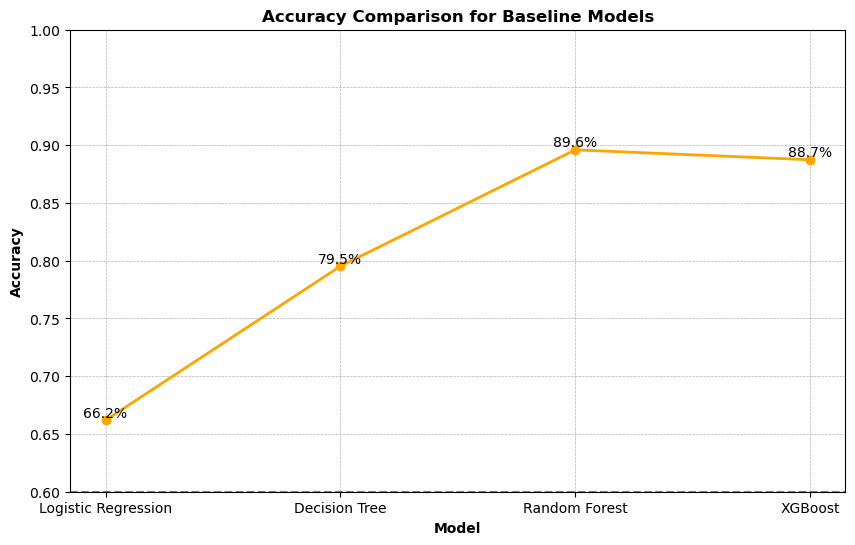

In [69]:
# List of model names and corresponding accuracy scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracy_scores = [accuracy_lg, accuracy_dt, accuracy_rf, accuracy_xgb]

# Plot the line graph with an orange color theme and grid lines
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy_scores, color='orange', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison for Baseline Models', fontweight='bold')
plt.ylim(0.6, 1.0)  # Set y-axis limits to 0.6 to 1.0
plt.axhline(y=0.6, color='gray', linestyle='--')  # Add a horizontal line at y=0.6 for reference

# Add accuracy score labels
for i, score in enumerate(accuracy_scores):
    plt.text(models[i], score, f"{score*100:.1f}%", ha='center', va='bottom')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add both horizontal and vertical grid lines
plt.show()

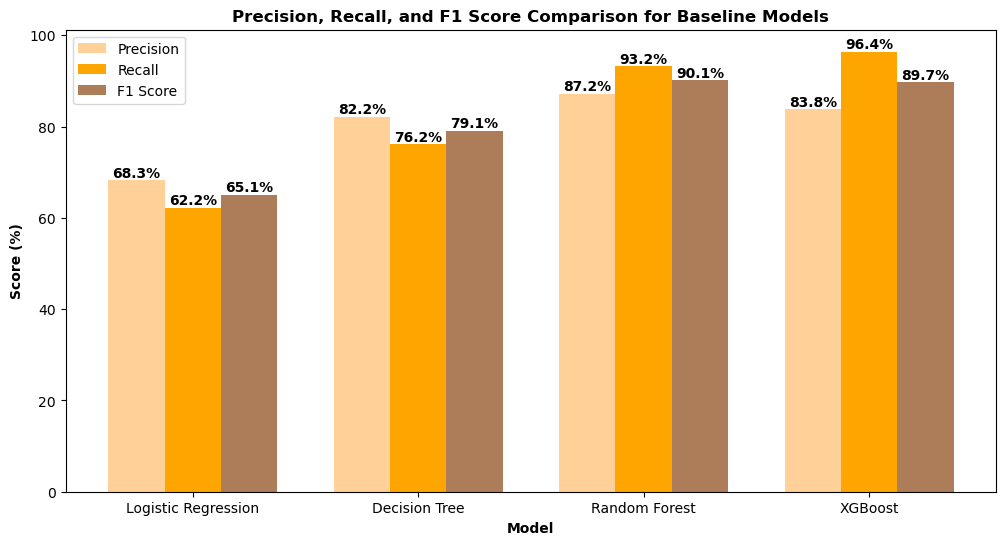

In [72]:
# List of model names and corresponding precision, recall, and F1 scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
precision_scores = [precision_lg, precision_dt, precision_rf, precision_xgb]
recall_scores = [recall_lg, recall_dt, recall_rf, recall_xgb]
f1_scores = [f1_lg, f1_dt, f1_rf, f1_xgb]

# Convert scores to percentages with one decimal place
precision_scores_pct = [round(score * 100, 1) for score in precision_scores]
recall_scores_pct = [round(score * 100, 1) for score in recall_scores]
f1_scores_pct = [round(score * 100, 1) for score in f1_scores]

# Set the positions and width for the bars
pos = np.arange(len(models))
width = 0.25

# Plot the bar graph for precision with an orange color theme
plt.figure(figsize=(12, 6))
plt.bar(pos, precision_scores_pct, width, color='darkorange', alpha=0.4, label='Precision')

# Plot the bar graph for recall with a darker orange color
plt.bar(pos + width, recall_scores_pct, width, color='orange', label='Recall')

# Plot the bar graph for F1 score with a much darker orange color
plt.bar(pos + 2 * width, f1_scores_pct, width, color='saddlebrown', alpha=0.7, label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score (%)', fontweight='bold')
plt.title('Precision, Recall, and F1 Score Comparison for Baseline Models', fontweight='bold')
plt.xticks(pos + width, models, rotation=360)
plt.legend()

# Add score labels on top of the bars
for i in range(len(models)):
    plt.text(pos[i], precision_scores_pct[i], f"{precision_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + width, recall_scores_pct[i], f"{recall_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + 2 * width, f1_scores_pct[i], f"{f1_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')

plt.show()

## Hyperparameter Tuning <a class="anchor" id="hyperparameter"></a>

### Logistic Regression <a class="anchor" id="a"></a>

In [21]:
# Initialize the model
log_reg = LogisticRegression(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],  
    'penalty': ['l1', 'l2']       
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
accuracy_tuned = accuracy_score(y_val, preds_tuned)
precision_tuned = precision_score(y_val, preds_tuned)
recall_tuned = recall_score(y_val, preds_tuned)
f1_tuned = f1_score(y_val, preds_tuned)
conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
print("Tuned Logistic Regression Metrics:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1 Score: {f1_tuned}")
print("Confusion Matrix:")
print(conf_mat_tuned)
print("Classification Report:")
print(clf_report_tuned)

Tuned Logistic Regression Metrics:
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.6635036496350365
Precision: 0.6876503608660786
Recall: 0.6169064748201439
F1 Score: 0.6503602578687904
Confusion Matrix:
[[1921  779]
 [1065 1715]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.71      0.68      2700
         1.0       0.69      0.62      0.65      2780

    accuracy                           0.66      5480
   macro avg       0.67      0.66      0.66      5480
weighted avg       0.67      0.66      0.66      5480



### Support Vector Machine <a class="anchor" id="b"></a>

This model will be tuned in the future, below is the code.

In [22]:
# Initialize the model
#svm = SVC(random_state=42)

# Define the hyperparameter grid to search
#param_grid = {
#    'C': [0.1, 1, 10],           
#    'kernel': ['linear', 'rbf']
#}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric
#grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
#grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
#best_params = grid_search.best_params_
#best_model = grid_search.best_estimator_

# Make predictions using the best model
#preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
#accuracy_tuned = accuracy_score(y_val, preds_tuned)
#precision_tuned = precision_score(y_val, preds_tuned)
#recall_tuned = recall_score(y_val, preds_tuned)
#f1_tuned = f1_score(y_val, preds_tuned)
#conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
#clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
#print("Tuned SVM Metrics:")
#print(f"Best Hyperparameters: {best_params}")
#print(f"Accuracy: {accuracy_tuned}")
#print(f"Precision: {precision_tuned}")
#print(f"Recall: {recall_tuned}")
#print(f"F1 Score: {f1_tuned}")
#print("Confusion Matrix:")
#print(conf_mat_tuned)
#print("Classification Report:")
#print(clf_report_tuned)

### Decision Tree <a class="anchor" id="c"></a>

In [23]:
# Initialize the model
dec_tree = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 10, 20, 30],   
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4]      
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric (F1 score)
grid_search = GridSearchCV(dec_tree, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
accuracy_tuned = accuracy_score(y_val, preds_tuned)
precision_tuned = precision_score(y_val, preds_tuned)
recall_tuned = recall_score(y_val, preds_tuned)
f1_tuned = f1_score(y_val, preds_tuned)
conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
print("Tuned Decision Tree Metrics:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1 Score: {f1_tuned}")
print("Confusion Matrix:")
print(conf_mat_tuned)
print("Classification Report:")
print(clf_report_tuned)

Tuned Decision Tree Metrics:
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.8021897810218979
Precision: 0.823170731707317
Recall: 0.7769784172661871
F1 Score: 0.7994078460399703
Confusion Matrix:
[[2236  464]
 [ 620 2160]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80      2700
         1.0       0.82      0.78      0.80      2780

    accuracy                           0.80      5480
   macro avg       0.80      0.80      0.80      5480
weighted avg       0.80      0.80      0.80      5480



### Random Forest <a class="anchor" id="d"></a>

In [24]:
# Initialize the model
rand_forest = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],         
    'max_depth': [None, 10, 20, 30],          
    'min_samples_split': [2, 5, 10],          
    'min_samples_leaf': [1, 2, 4]           
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric (F1 score)
grid_search = GridSearchCV(rand_forest, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
accuracy_tuned = accuracy_score(y_val, preds_tuned)
precision_tuned = precision_score(y_val, preds_tuned)
recall_tuned = recall_score(y_val, preds_tuned)
f1_tuned = f1_score(y_val, preds_tuned)
conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
print("Tuned Random Forest Metrics:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1 Score: {f1_tuned}")
print("Confusion Matrix:")
print(conf_mat_tuned)
print("Classification Report:")
print(clf_report_tuned)

Tuned Random Forest Metrics:
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.8989051094890511
Precision: 0.8714953271028038
Recall: 0.9392086330935252
F1 Score: 0.9040858725761773
Confusion Matrix:
[[2315  385]
 [ 169 2611]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89      2700
         1.0       0.87      0.94      0.90      2780

    accuracy                           0.90      5480
   macro avg       0.90      0.90      0.90      5480
weighted avg       0.90      0.90      0.90      5480



### XGBoost <a class="anchor" id="e"></a>

In [26]:
# Initialize the model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],      
    'max_depth': [3, 5, 7],               
    'learning_rate': [0.01, 0.1, 0.2]     
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric (F1 score)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
accuracy_tuned = accuracy_score(y_val, preds_tuned)
precision_tuned = precision_score(y_val, preds_tuned)
recall_tuned = recall_score(y_val, preds_tuned)
f1_tuned = f1_score(y_val, preds_tuned)
conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
print("Tuned XGBoost Metrics:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1 Score: {f1_tuned}")
print("Confusion Matrix:")
print(conf_mat_tuned)
print("Classification Report:")
print(clf_report_tuned)

[12:41:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:42:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:42:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters a

KeyboardInterrupt: 

### Summary of Hyperparameter Tuning

In [27]:
# Set the maximum column width to -1 to display all the text in a column
pd.set_option('display.max_colwidth', -1)

# Create a DataFrame with the best parameters for each model
best_params_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Best Parameters': [
        {'C': 0.1, 'penalty': 'l2'},
        {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2},
        {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300},
        {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
    ]
})

print(best_params_df)

                 Model  \
0  Logistic Regression   
1  Decision Tree         
2  Random Forest         
3  XGBoost               

                                                                              Best Parameters  
0  {'C': 0.1, 'penalty': 'l2'}                                                                 
1  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}  
2  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}     
3  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}                                 


## Fit the models with the best parameters <a class="anchor" id="tune"></a>

### Logistic Regression

In [28]:
# Fit the model
log_reg_model  = LogisticRegression(C=0.1, penalty='l2', random_state=42)
log_reg_model.fit(X_train, y_train)

# Make predictions
preds = log_reg_model.predict(X_val)

# Compute metrics
accuracy_lg1 = accuracy_score(y_val, preds)
precision_lg1 = precision_score(y_val, preds)
recall_lg1 = recall_score(y_val, preds)
f1_lg1 = f1_score(y_val, preds)
conf_mat_lg1 = confusion_matrix(y_val, preds)
clf_report_lg1 = classification_report(y_val, preds)

# Print metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lg1}")
print(f"Precision: {precision_lg1}")
print(f"Recall: {recall_lg1}")
print(f"F1 Score: {f1_lg1}")
print("Confusion Matrix:")
print(conf_mat_lg1)
print("Classification Report:")
print(clf_report_lg1)

Logistic Regression Metrics:
Accuracy: 0.6635036496350365
Precision: 0.6876503608660786
Recall: 0.6169064748201439
F1 Score: 0.6503602578687904
Confusion Matrix:
[[1921  779]
 [1065 1715]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.71      0.68      2700
         1.0       0.69      0.62      0.65      2780

    accuracy                           0.66      5480
   macro avg       0.67      0.66      0.66      5480
weighted avg       0.67      0.66      0.66      5480



### Decision Tree

In [29]:
# Fit the model
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
preds = dt_model.predict(X_val)

# Compute metrics
accuracy_dt1 = accuracy_score(y_val, preds)
precision_dt1 = precision_score(y_val, preds)
recall_dt1 = recall_score(y_val, preds)
f1_dt1 = f1_score(y_val, preds)
conf_mat_dt1 = confusion_matrix(y_val, preds)
clf_report_dt1 = classification_report(y_val, preds)

# Print metrics
print("Decision Tree Metrics:")
print(f"Accuracy: {accuracy_dt1}")
print(f"Precision: {precision_dt1}")
print(f"Recall: {recall_dt1}")
print(f"F1 Score: {f1_dt1}")
print("Confusion Matrix:")
print(conf_mat_dt1)
print("Classification Report:")
print(clf_report_dt1)

Decision Tree Metrics:
Accuracy: 0.8021897810218979
Precision: 0.823170731707317
Recall: 0.7769784172661871
F1 Score: 0.7994078460399703
Confusion Matrix:
[[2236  464]
 [ 620 2160]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80      2700
         1.0       0.82      0.78      0.80      2780

    accuracy                           0.80      5480
   macro avg       0.80      0.80      0.80      5480
weighted avg       0.80      0.80      0.80      5480



### Random Forest

In [30]:
# Fit the model
rf_model = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
preds = rf_model.predict(X_val)

# Compute metrics
accuracy_rf1 = accuracy_score(y_val, preds)
precision_rf1 = precision_score(y_val, preds)
recall_rf1 = recall_score(y_val, preds)
f1_rf1 = f1_score(y_val, preds)
conf_mat_rf1 = confusion_matrix(y_val, preds)
clf_report_rf1 = classification_report(y_val, preds)

# Print metrics
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_rf1}")
print(f"Precision: {precision_rf1}")
print(f"Recall: {recall_rf1}")
print(f"F1 Score: {f1_rf1}")
print("Confusion Matrix:")
print(conf_mat_rf1)
print("Classification Report:")
print(clf_report_rf1)

Random Forest Metrics:
Accuracy: 0.8989051094890511
Precision: 0.8714953271028038
Recall: 0.9392086330935252
F1 Score: 0.9040858725761773
Confusion Matrix:
[[2315  385]
 [ 169 2611]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89      2700
         1.0       0.87      0.94      0.90      2780

    accuracy                           0.90      5480
   macro avg       0.90      0.90      0.90      5480
weighted avg       0.90      0.90      0.90      5480



### XGBoost

In [31]:
# Fit the model
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions
preds = xgb_model.predict(X_val)

# Compute metrics
accuracy_xgb1 = accuracy_score(y_val, preds)
precision_xgb1 = precision_score(y_val, preds)
recall_xgb1 = recall_score(y_val, preds)
f1_xgb1 = f1_score(y_val, preds)
conf_mat_xgb1 = confusion_matrix(y_val, preds)
clf_report_xgb1 = classification_report(y_val, preds)

# Print metrics
print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_xgb1}")
print(f"Precision: {precision_xgb1}")
print(f"Recall: {recall_xgb1}")
print(f"F1 Score: {f1_xgb1}")
print("Confusion Matrix:")
print(conf_mat_xgb1)
print("Classification Report:")
print(clf_report_xgb1)

[14:06:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost Metrics:
Accuracy: 0.8877737226277372
Precision: 0.8354508831732259
Recall: 0.9697841726618706
F1 Score: 0.897619443982021
Confusion Matrix:
[[2169  531]
 [  84 2696]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.80      0.88      2700
         1.0       0.84      0.97      0.90      2780

    accuracy                           0.89      5480
   macro avg       0.90      0.89      0.89      5480
weighted avg       0.90      0.89      0.89      5480



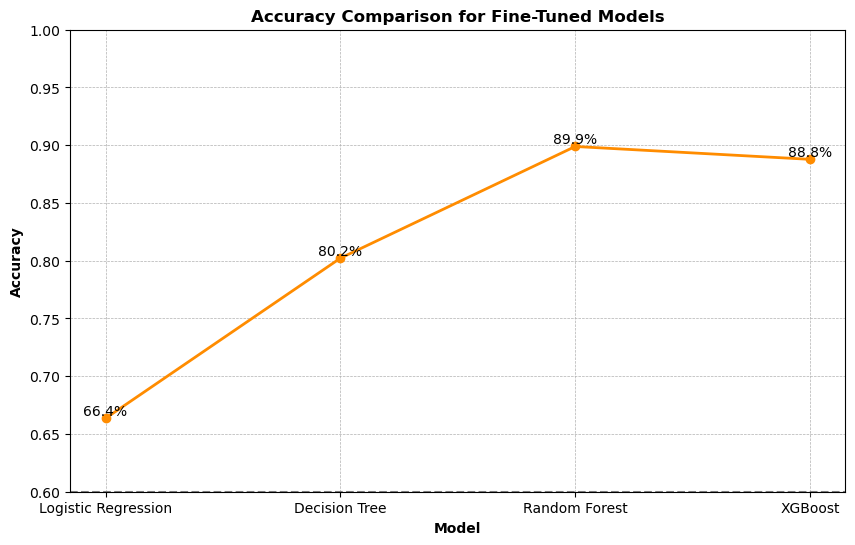

In [74]:
# List of model names and corresponding accuracy scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracy_scores = [accuracy_lg1, accuracy_dt1, accuracy_rf1, accuracy_xgb1]

# Plot the line graph with an orange color theme and grid lines
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy_scores, color='darkorange', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison for Fine-Tuned Models', fontweight='bold')
plt.ylim(0.6, 1.0)  # Set y-axis limits to 0.6 to 1.0
plt.axhline(y=0.6, color='gray', linestyle='--')  # Add a horizontal line at y=0.6 for reference

# Add accuracy score labels
for i, score in enumerate(accuracy_scores):
    plt.text(models[i], score, f"{score*100:.1f}%", ha='center', va='bottom')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add both horizontal and vertical grid lines
plt.show()

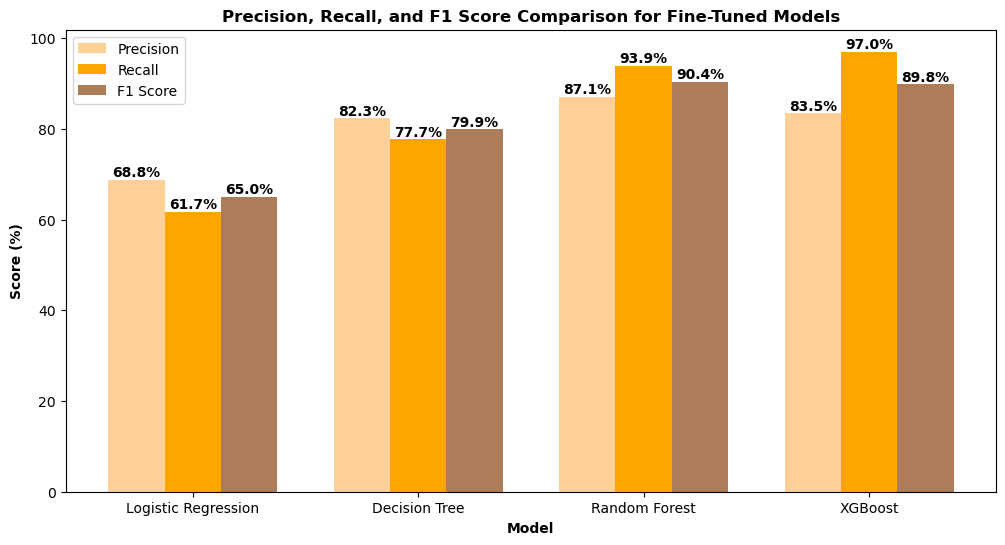

In [64]:
# List of model names and corresponding precision, recall, and F1 scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
precision_scores = [precision_lg1, precision_dt1, precision_rf1, precision_xgb1]
recall_scores = [recall_lg1, recall_dt1, recall_rf1, recall_xgb1]
f1_scores = [f1_lg1, f1_dt1, f1_rf1, f1_xgb1]

# Convert scores to percentages with one decimal place
precision_scores_pct = [round(score * 100, 1) for score in precision_scores]
recall_scores_pct = [round(score * 100, 1) for score in recall_scores]
f1_scores_pct = [round(score * 100, 1) for score in f1_scores]

# Set the positions and width for the bars
pos = np.arange(len(models))
width = 0.25

# Plot the bar graph for precision with an orange color theme
plt.figure(figsize=(12, 6))
plt.bar(pos, precision_scores_pct, width, color='darkorange', alpha=0.4, label='Precision')

# Plot the bar graph for recall with a darker orange color
plt.bar(pos + width, recall_scores_pct, width, color='orange', label='Recall')

# Plot the bar graph for F1 score with a much darker orange color
plt.bar(pos + 2 * width, f1_scores_pct, width, color='saddlebrown', alpha=0.7, label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score (%)', fontweight='bold')
plt.title('Precision, Recall, and F1 Score Comparison for Fine-Tuned Models', fontweight='bold')
plt.xticks(pos + width, models, rotation=360)
plt.legend()

# Add score labels on top of the bars
for i in range(len(models)):
    plt.text(pos[i], precision_scores_pct[i], f"{precision_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + width, recall_scores_pct[i], f"{recall_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + 2 * width, f1_scores_pct[i], f"{f1_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')

plt.show()

### Summary of Tuned Models

In [32]:
# Create an empty DataFrame to store the metrics
tuned_metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Add the metrics for the tuned models
tuned_metrics_df.loc['Logistic Regression'] = [accuracy_lg1, precision_lg1, recall_lg1, f1_lg1]
tuned_metrics_df.loc['Decision Tree'] = [accuracy_dt1, precision_dt1, recall_dt1, f1_dt1]
tuned_metrics_df.loc['Random Forest'] = [accuracy_rf1, precision_rf1, recall_rf1, f1_rf1]
tuned_metrics_df.loc['XGBoost'] = [accuracy_xgb1, precision_xgb1, recall_xgb1, f1_xgb1]

# Print the comparison table
print(tuned_metrics_df)

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.663504  0.687650   0.616906  0.650360
Decision Tree        0.802190  0.823171   0.776978  0.799408
Random Forest        0.898905  0.871495   0.939209  0.904086
XGBoost              0.887774  0.835451   0.969784  0.897619


## Compare Baseline Models vs. Tuned Models

In [33]:
# Rename the index for the baseline models
metrics_df.index = ['Baseline Logistic Regression', #'Baseline SVM', 
                    'Baseline Decision Tree', 'Baseline Random Forest', 'Baseline XGBoost']

# Rename the index for the tuned models
tuned_metrics_df.index = ['Tuned Logistic Regression', 'Tuned Decision Tree', 
                          'Tuned Random Forest', 'Tuned XGBoost']

# Reorder the rows
all_metrics_df = pd.concat([
    metrics_df.loc[['Baseline Logistic Regression']],
    tuned_metrics_df.loc[['Tuned Logistic Regression']],
    #metrics_df.loc[['Baseline SVM']],
    metrics_df.loc[['Baseline Decision Tree']],
    tuned_metrics_df.loc[['Tuned Decision Tree']],
    metrics_df.loc[['Baseline Random Forest']],
    tuned_metrics_df.loc[['Tuned Random Forest']],
    metrics_df.loc[['Baseline XGBoost']],
    tuned_metrics_df.loc[['Tuned XGBoost']]
])

# Print the comparison table
print(all_metrics_df)


                              Accuracy  Precision    Recall  F1 Score
Baseline Logistic Regression  0.661861  0.682985   0.622302  0.651233
Tuned Logistic Regression     0.663504  0.687650   0.616906  0.650360
Baseline Decision Tree        0.795255  0.821817   0.761511  0.790515
Tuned Decision Tree           0.802190  0.823171   0.776978  0.799408
Baseline Random Forest        0.895985  0.871803   0.932014  0.900904
Tuned Random Forest           0.898905  0.871495   0.939209  0.904086
Baseline XGBoost              0.887409  0.838498   0.963669  0.896736
Tuned XGBoost                 0.887774  0.835451   0.969784  0.897619


## ROC AUC Curve

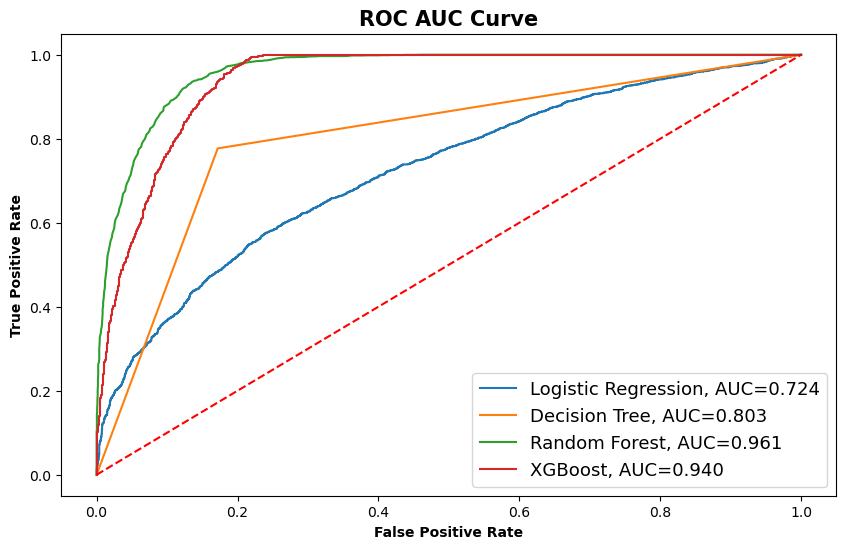

In [75]:
# Define a list to store the results for each model
model_results = []

# Logistic Regression
fpr, tpr, thresholds = roc_curve(y_val, log_reg_model.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
model_results.append(('Logistic Regression', roc_auc, fpr, tpr))

# Decision Tree
fpr, tpr, thresholds = roc_curve(y_val, dt_model.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
model_results.append(('Decision Tree', roc_auc, fpr, tpr))

# Random Forest
fpr, tpr, thresholds = roc_curve(y_val, rf_model.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
model_results.append(('Random Forest', roc_auc, fpr, tpr))

# XGBoost
fpr, tpr, thresholds = roc_curve(y_val, xgb_model.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
model_results.append(('XGBoost', roc_auc, fpr, tpr))

# Plot the ROC AUC curve with index labeling
fig = plt.figure(figsize=(10, 6))

for name, auc_score, fpr_val, tpr_val in model_results:
    plt.plot(fpr_val, tpr_val, label="{}, AUC={:.3f}".format(name, auc_score))

plt.plot([0, 1], [0, 1], 'r--')

plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')

plt.title('ROC AUC Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size': 13}, loc='lower right')

plt.show()

The ROC AUC curve is a graphical representation of the performance of different models in binary classification tasks. It illustrates the trade-off between the true positive rate (sensitivity or recall) and the false positive rate (1-specificity) as the discrimination threshold of the model is varied.

In the graph, each colored line corresponds to a different model, and the label for each line shows the model name along with its corresponding AUC score. The AUC (Area Under the Curve) represents the overall performance of the model, and a higher AUC indicates better discrimination power and better model performance.

Interpretation of the ROC AUC Curve:

A perfect model would have an AUC of 1, meaning it can achieve 100% true positive rate with 0% false positive rate. This would be represented by a point at the top-left corner of the graph.
The diagonal dashed line in red represents a random classifier with an AUC of 0.5. A random classifier has no discriminative power and its true positive rate is equal to its false positive rate.
Points above the diagonal line represent models with better-than-random performance, while points below the diagonal line represent models with worse-than-random performance.
Interpreting Model Performance:

Models with ROC curves closer to the top-left corner indicate higher performance. The closer the ROC curve is to the top-left corner, the better the model is at distinguishing between the positive and negative classes.
Models with AUC scores close to 1 indicate excellent performance, while models with AUC scores closer to 0.5 suggest poor performance, similar to random guessing.

### In this specific graph:

- The "Random Forest" and "XGBoost" models seem to perform similarly, as their ROC curves are close to each other and have similar AUC scores.
- However, the "Random Forest" model has the highest AUC score among all the models, suggesting it has the best performance on the validation data.
- The "Logistic Regression" model has the lowest AUC score, indicating that it performs the worst among the models.

Overall, the ROC AUC curve provides a visual and intuitive way to compare the performance of different models and select the best-performing model for the classification task. In this case, the "Random Forest" model appears to be the best choice among the models evaluated.

## Model Selection <a class="anchor" id="select"></a>

### Random Forest model 

Reasoning:

The **F1 score** is the harmonic mean of precision and recall, and it gives a balanced measure of these two metrics. It ranges from 0 to 1, where 1 indicates perfect precision and recall.

- **Precision** is the proportion of true positive predictions (in this case, correctly predicted defaults) out of all positive predictions. A high precision means that when the model predicts a loan will default, it is very likely to actually default. However, precision does not take into account the loans that actually default but were not predicted by the model (false negatives).
- **Recall** (also known as sensitivity or true positive rate) is the proportion of true positive predictions out of all actual positives. A high recall means that the model is good at catching defaults and labeling them as such. However, recall does not consider the loans that were predicted as defaults but did not actually default (false positives).

Since we care about both catching as many defaults as possible (high recall) and being accurate in our predictions of defaults (high precision), then the F1 score is a good metric to look at because it balances these two aspects.

In our case, the tuned Random Forest model has the highest F1 score, meaning it has the best balance of precision and recall among all the models we've trained. It is capable of both capturing a high proportion of the actual defaults and maintaining a high confidence in its default predictions.

Therefore, the tuned **Random Forest model** is the best choice according to the F1 score, since we're looking for a balance between precision and recall.

## Model Evaluation <a class="anchor" id="evaluate"></a>

### Random Forest model

In [37]:
# Split the test data into features and target variable
X_test = test_df.drop('loan_status', axis=1)
y_test = test_df['loan_status']

# Fit the model on the training data
rf_model = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test data using the selected model
y_test_pred = rf_model.predict(X_test)

# Compute the metrics
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)
clf_report_test = classification_report(y_test, y_test_pred)

# Print the metrics
print("Test Accuracy: ", accuracy_test)
print("Test Precision: ", precision_test)
print("Test Recall: ", recall_test)
print("Test F1 Score: ", f1_test)
print("Test Confusion Matrix: \n", conf_mat_test)
print("Test Classification Report: \n", clf_report_test)

Test Accuracy:  0.796976241900648
Test Precision:  0.8401477182801371
Test Recall:  0.92992700729927
Test F1 Score:  0.8827605321507761
Test Confusion Matrix: 
 [[ 136  606]
 [ 240 3185]]
Test Classification Report: 
               precision    recall  f1-score   support

         0.0       0.36      0.18      0.24       742
         1.0       0.84      0.93      0.88      3425

    accuracy                           0.80      4167
   macro avg       0.60      0.56      0.56      4167
weighted avg       0.75      0.80      0.77      4167



Interpret the results:

- Test Accuracy: The model correctly predicted the loan status for approximately 80% of the loans in the test data.
- Test Precision (for the positive class): When the model predicted a loan would be paid, it was correct about 84% of the time.
- Test Recall (for the positive class): The model correctly identified 93% of the loans that were actually paid.
- Test F1 Score (for the positive class): The F1 score is the harmonic mean of precision and recall. An F1 score of 0.88 indicates that the model is doing well at both precision and recall. However, because the dataset is imbalanced, the F1 score is more representative for the majority class (loans that were paid).
- Confusion Matrix: The confusion matrix gives us a more detailed breakdown of the model's performance. It shows that the model is having more difficulty correctly predicting the negative class (defaulted loans).

From this evaluation, it's clear that the model is performing well on the positive class (loans that were paid), but not as well on the negative class (defaulted loans). This could be due to the imbalance in the dataset, with many more loans being paid than defaulted. 

However, with the limitation of the available data in the current dataset, we should be satisfied with the model's performance.

### Save the Tuned Models

In [48]:
# Specify the directory
directory = './model/'

# Save Logistic Regression model
with open(os.path.join(directory, 'logistic_regression_model.pkl'), 'wb') as file:
    pickle.dump(log_reg_model, file)

# Save Decision Tree model
with open(os.path.join(directory, 'decision_tree_model.pkl'), 'wb') as file:
    pickle.dump(dt_model, file)

# Save Random Forest model
with open(os.path.join(directory, 'random_forest_model.pkl'), 'wb') as file:
    pickle.dump(rf_model, file)

# Save XGBoost model
with open(os.path.join(directory, 'xgboost_model.pkl'), 'wb') as file:
    pickle.dump(xgb_model, file)